In [ ]:
!pip install kaggle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files


In [ ]:
#upload kaggle.json when prompted!

files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c nfl-big-data-bowl-2025 -f games.csv
!kaggle competitions download -c nfl-big-data-bowl-2025 -f plays.csv
!kaggle competitions download -c nfl-big-data-bowl-2025 -f player_play.csv
!kaggle competitions download -c nfl-big-data-bowl-2025 -f players.csv

Saving kaggle.json to kaggle.json
  0% 0.00/6.96k [00:00<?, ?B/s]
100% 6.96k/6.96k [00:00<00:00, 15.6MB/s]
  0% 0.00/6.57M [00:00<?, ?B/s]
100% 6.57M/6.57M [00:00<00:00, 69.2MB/s]
 72% 36.0M/50.1M [00:00<00:00, 52.6MB/s]
100% 50.1M/50.1M [00:00<00:00, 70.2MB/s]
  0% 0.00/102k [00:00<?, ?B/s]
100% 102k/102k [00:00<00:00, 4.42MB/s]


In [ ]:
games = pd.read_csv('games.csv')
player_plays = pd.read_csv('player_play.csv')
players = pd.read_csv('players.csv')
plays = pd.read_csv('plays.csv')
#use 2022 season play-by-play data to provide further support
# pbp_lookup = nfl.import_pbp_data([2022])

In [ ]:
# #coverage cleaning (Don't change this cell)
# def drop_condition(val):
#   s=val['pff_passCoverage']
#   if s=='Red Zone' or s=='Goal Line' or s=='Bracket' or s=='Prevent' or s=='Miscellaneous':
#     return False
#   else:
#     return True

# def update_coverage(s):
#   if 'Cover-3' in s:
#     return 'Cover-3'
#   elif 'Cover-1' in s:
#     return 'Cover-1'
#   elif '6' in s:
#     return 'Cover-6'
#   else:
#     return s


plays['game_and_playId'] = plays['gameId'].astype(str) + '_' + plays['playId'].astype(str)
player_plays['game_and_playId'] = player_plays['gameId'].astype(str) + '_' + player_plays['playId'].astype(str)

In [ ]:
plays_filtered = plays[(plays['qbSpike']!=1) & (plays['qbKneel']!=True) & (plays['playNullifiedByPenalty'] != 'Y')]
temp = player_plays[player_plays['game_and_playId'].isin(plays_filtered.game_and_playId)]
temp = temp[temp['motionSinceLineset']==True].drop_duplicates(subset=['game_and_playId'])
plays_filtered=plays_filtered.merge(temp[['motionSinceLineset','game_and_playId']],on='game_and_playId',how='left')
plays_filtered.fillna({'motionSinceLineset':False},inplace=True)
plays_filtered
#compare offensive results with vs without motion
plays_filtered.groupby('motionSinceLineset')['expectedPointsAdded'].mean()

,expectedPointsAdded
motionSinceLineset,
False,-0.076082
True,0.074917


In [ ]:

#filter plays to only include plays with motion
plays_filtered = plays[(plays['qbSpike']!=1) & (plays['qbKneel']!=True) & (plays['playNullifiedByPenalty'] != 'Y')]

temp = player_plays[player_plays['game_and_playId'].isin(plays_filtered.game_and_playId)]
temp = temp[temp['motionSinceLineset']==True]
plays_filtered = plays_filtered[plays_filtered['game_and_playId'].isin(temp.game_and_playId)]
# plays_filtered = plays_filtered[plays_filtered['pff_passCoverage'].notnull()]
# plays_filtered = plays_filtered[plays_filtered.apply(drop_condition,axis=1)]
# plays_filtered['pff_passCoverage'] = plays_filtered['pff_passCoverage'].apply(update_coverage)

In [ ]:
#now plays_filtered only includes plays with motion
plays_filtered.head(10)

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,game_and_playId
9,2022100204,1422,(5:22) (Shotgun) C.Rush pass short left to M.G...,2,3,8,DAL,WAS,DAL,35,...,0.058490,-0.058490,2.194760,True,NaN,NaN,0,Quarters,Zone,2022100204_1422
11,2022102306,3240,(12:55) (Shotgun) A.Dillon left tackle to WAS ...,4,2,10,GB,WAS,WAS,46,...,0.053308,-0.053308,-0.962012,False,PULL LEAD,NaN,0,Cover-6 Right,Zone,2022102306_3240
12,2022091112,1674,(:35) (Shotgun) A.Rodgers pass deep left inten...,2,1,10,GB,MIN,GB,25,...,0.003262,-0.003262,-1.071627,True,NaN,NaN,0,Cover-2,Zone,2022091112_1674
19,2022100207,681,(4:32) R.Tannehill pass deep left to C.Okonkwo...,1,1,10,TEN,IND,IND,42,...,-0.051718,0.051718,1.438245,True,OUTSIDE ZONE,NaN,0,Cover-3,Zone,2022100207_681
23,2022092506,1412,(8:41) J.Burrow pass incomplete short right to...,2,1,4,CIN,NYJ,NYJ,4,...,0.000298,-0.000298,-0.402760,True,OUTSIDE ZONE,NaN,0,Cover-0,Man,2022092506_1412
30,2022091803,1222,(6:03) (Shotgun) M.Ryan pass incomplete short ...,2,3,6,IND,JAX,IND,26,...,0.009804,-0.009804,-1.418779,True,NaN,NaN,0,2-Man,Man,2022091803_1222
34,2022101608,1317,(3:39) M.Stafford pass short left to Al.Robins...,2,1,5,LA,CAR,CAR,5,...,0.020604,-0.020604,1.344132,True,MAN,NaN,1,Cover-0,Man,2022101608_1317
35,2022091806,346,(9:31) (Shotgun) D.Harris up the middle to PIT...,1,1,10,NE,PIT,PIT,31,...,-0.012754,0.012754,0.771582,False,MAN,NaN,0,Quarters,Zone,2022091806_346
36,2022092506,226,(11:59) (Shotgun) J.Burrow pass short left to ...,1,2,15,CIN,NYJ,NYJ,33,...,0.002945,-0.002945,0.087709,True,NaN,NaN,0,Cover-6 Right,Zone,2022092506_226
41,2022092503,1755,(2:00) 5-T. Bridgewater in at QB. (Shotgun) T....,2,1,10,MIA,BUF,MIA,44,...,-0.002589,0.002589,-0.372914,True,NaN,NaN,0,Quarters,Zone,2022092503_1755


In [ ]:
#make sure to use plays_filtered dataframe rather than plays



In [ ]:
# Group by team and calculate zone coverage rate
team_coverage = plays_filtered.groupby('defensiveTeam')['pff_manZone'].value_counts(normalize=True).unstack(fill_value=0)
team_coverage['zone_rate'] = team_coverage['Zone'] / (team_coverage['Zone'] + team_coverage['Man'])
team_coverage = team_coverage.reset_index()

team_coverage = team_coverage.sort_values(by=['zone_rate'], ascending=False)
team_coverage[['defensiveTeam', 'zone_rate']]



pff_manZone,defensiveTeam,zone_rate
16,LA,0.947826
9,DEN,0.855769
20,MIN,0.852459
27,SEA,0.823529
13,IND,0.818750
25,PHI,0.794118
5,CHI,0.772414
12,HOU,0.771654
2,BAL,0.761111
11,GB,0.756098


In [ ]:
# additional checking of Filter plays with motion
#merged_df = pd.merge(plays_filtered, player_plays, on=['gameId', 'playId'], how='inner')
#motion_plays = merged_df[merged_df['motionSinceLineset'] == True]

#print(motion_plays.columns)
#look up the epa allowed from the official NFL dataset since there is no readily available epa in the dataset
# epa_lookup = pbp_lookup[['play_id', 'epa']]
# motion_plays = plays_filtered
# motion_plays = pd.merge(motion_plays, epa_lookup, left_on='playId', right_on='play_id', how='left')
# Group by team and calculate average EPA allowed
defensive_team_epa = plays_filtered.groupby('defensiveTeam')['expectedPointsAdded'].mean().reset_index()
defensive_team_epa= defensive_team_epa.rename(columns={'expectedPointsAdded': 'defensive_epa'})
# Display the result
defensive_team_epa.sort_values(by=['defensive_epa'], ascending=False)

,defensiveTeam,defensive_epa
18,LV,0.411862
0,ARI,0.333506
1,ATL,0.231979
3,BUF,0.228801
8,DAL,0.196749
10,DET,0.180744
15,KC,0.158219
26,PIT,0.142596
27,SEA,0.131728
24,NYJ,0.121365


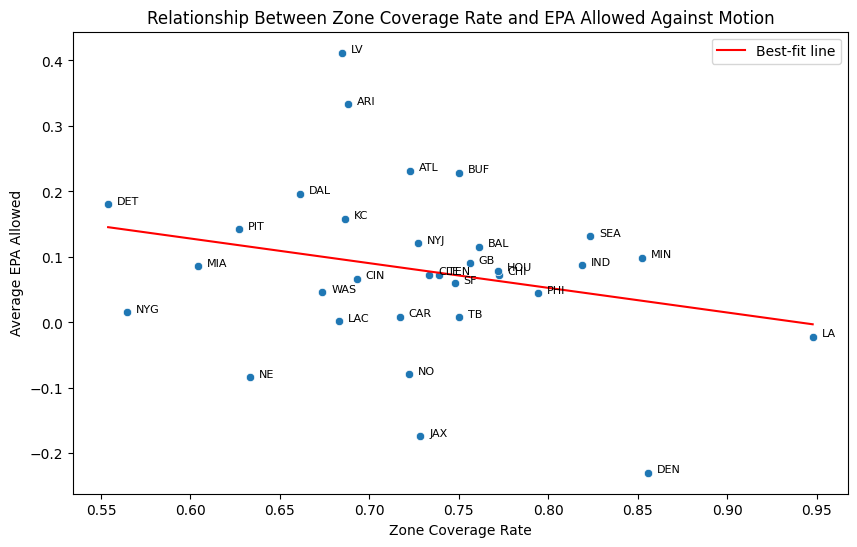

In [ ]:
# Merge the two dataframes (man/zone coverage and defensive epa on 'defensiveTeam')
team_stats = pd.merge(team_coverage, defensive_team_epa, on='defensiveTeam')

# Display the result
team_stats[['defensiveTeam', 'zone_rate', 'defensive_epa']].head()

# Create the scatterplot and the best-fit line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='zone_rate', y='defensive_epa', data=team_stats)
plt.title('Relationship Between Zone Coverage Rate and EPA Allowed Against Motion')
plt.xlabel('Zone Coverage Rate')
plt.ylabel('Average EPA Allowed')
for i in range(team_stats.shape[0]):
    plt.text(team_stats.zone_rate[i] + 0.005, team_stats.defensive_epa[i], team_stats.defensiveTeam[i], fontsize=8)
slope, intercept = np.polyfit(team_stats.zone_rate, team_stats.defensive_epa, 1)
x_values = np.array([team_stats.zone_rate.min(), team_stats.zone_rate.max()])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, color='red', label='Best-fit line')
plt.legend()
plt.show()

In [ ]:
plays_filtered.groupby('pff_manZone')['expectedPointsAdded'].mean()

,expectedPointsAdded
pff_manZone,
Man,0.132665
Zone,0.055017
